In [1]:
!pip install -r gen_ai/requirements.txt

In [2]:
import torch

if torch.cuda.is_available():
    print("GPU Name:", torch.cuda.get_device_name(0))
else:
    print("No GPU found.")


GPU Name: NVIDIA GeForce RTX 3090


## Load embeddings from here



In [3]:
##################################################################################################################################################################

In [4]:
import pickle
from typing import List, Literal
from langgraph.graph import StateGraph, START, END
from typing_extensions import TypedDict
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
import torch
import copy
import json
from typing import List, Dict
import transformers
import string



from langchain.tools import BaseTool, Tool  # Para criar ferramentas personalizadas
#from langchain.agents import initialize_agent  # Para configurar o agente
#from langchain.chat_models import ChatOpenAI  # Para usar modelos de linguagem



thread_states = {}

# Definir o schema de estado
#class EmbeddingDict(TypedDict):
    #key1: str
    #key2: str
    #key3: str
    #key4: List[float]

class State(TypedDict):
    graph_state: str
    query: str
    embeddings_loaded: bool
    query_template: str
    query_embedding: List
    metadados: List
    top_results: List
    llm_response: str
    thread: str
    context_decision: str
    tool_result: str
    # Adicione outros campos conforme necessário

# Variável global para armazenar embeddings na memória
embeddings_in_memory = None
# Load model and tokenizer
model_id = "meta-llama/Meta-Llama-3.1-8B-Instruct"  # Replace if needed
tokenizer = AutoTokenizer.from_pretrained(model_id)

# Configure BitsAndBytes for 4-bit quantization
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,  # Enable 4-bit quantization
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=False,
    bnb_4bit_quant_type="fp4",
)

model = AutoModelForCausalLM.from_pretrained(
    model_id,
    quantization_config=bnb_config,  # Correct quantization parameter
    device_map="auto",
)

pipeline = transformers.pipeline(
    "text-generation",
    model=model_id,
    model_kwargs={"torch_dtype": torch.bfloat16},
    device_map="auto",
)

#embddings model
from sentence_transformers import SentenceTransformer
embeddings_model = SentenceTransformer("sentence-transformers/gtr-t5-large")



/opt/conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading checkpoint shards: 100%|██████████| 4/4 [00:02<00:00,  1.34it/s]


## functions

In [5]:
# Function: Decidir o próximo nó com base no estado atualizado
def decide_next_node_embeddings(state: State) -> Literal["load_embeddings_files", "create_query_embedding"]:
    if state["embeddings_loaded"] == True:
        print("will NOT load embeddings")
        return "create_query_embedding"
    else:
        print("laoding embeddings")
        return "load_embeddings_files"

# Function: Decidir o próximo nó com base no estado atualizado
def decide_next_node_context(state: State) -> Literal["use_RAG", "specific_tool_node", "general_tool_node"]:
    print(state["context_decision"])
    if "SPECIFIC" in state["context_decision"] or "specific" in state["context_decision"]:
        return "specific_tool_node"
    elif "GENERAL" in state["context_decision"] or "general" in state["context_decision"]:
        return "general_tool_node"
    else:       
        return "use_RAG"
    
# Function: Decidir o próximo nó com base no histórico
def decide_next_node_history(state: State) -> Literal["bring_conversation_history", "build_prompt_template"]:    
    if 1==1:
        
        return "bring_conversation_history"
    else:
        
        return "build_prompt_template"

# Function: Decidir o próximo nó com base no estado atualizado
def decide_next_node_short(state: State) -> Literal["make_history_short", END]:
    if 1==1:
        return "make_history_short"
    else:
        return END

# Func: cria mensagem de sistema
def create_system_message(context_list) -> str:
    
    formatted_context = []
    for result in context_list:
        try:
            # Formatar os metadados seguidos pelo texto
            formatted_entry = (
                f"Document: {result['document_name']}\n"
                f"Page: {result['page_num']}\n"
                f"Text: {result['text']}\n"
                "----------------------\n"
                )
        except:
            formatted_entry = str(result)

        formatted_context.append(formatted_entry)    
    # Juntar todos os textos formatados em uma única string
    final_context = "\n".join(formatted_context)
    system_message_and_context = (
    "Check if the userer's quesiton can be answered by the content present in the context: "
    "If the answer is not in the context, say that you don't know. "
    "If the answer is in the context, just reply it based on context. "
   f"<context>{final_context}</context>"    
    )
    return system_message_and_context

def load_data(file_path: str) -> List[Dict]:
    """
    Carrega os dados estruturados do arquivo JSON.
    """
    with open(file_path, 'r') as f:
        return json.load(f)

#from typing import List, Dict
#from langchain.tools import BaseTool



In [6]:
DESCRIPTION_SPECIFIC_TOOL = """
Use it to answer questions about prices or cost of the plans.
"""

DESCRIPTION_GENERAL_TOOL = """
Use it to anser about features available in each plan.
"""

DESCRIPTION_RAG = """
Use it to answer any other type of question.
"""



## Tools

In [7]:
from langchain.tools import BaseTool

class SpecificFilterTool(BaseTool):
    name:str = "specific_filter"
    description:str = (
        "Use esta ferramenta para buscar apenas as informações mais relevantes com base em palavras-chave na consulta. "
        "Ideal para perguntas como: 'Qual o custo do plano Standard?'."
    )

    file_path:str = '/home/jovyan/gen_ai/structured_subscription_data_with_categories.json'

    def _run(self, query: str):
        data = load_data(self.file_path)        
        
        return data

    def _arun(self, query: str):
        raise NotImplementedError("Esta ferramenta não suporta execução assíncrona.")

class GeneralFilterTool(BaseTool):
    name: str = "general_filter"
    description: str = (
        "Use esta ferramenta para buscar todas as informações relacionadas com base em palavras-chave na consulta. "
        "Ideal para perguntas como: 'Quais são todas as características do plano Standard?'."
    )

    file_path: str = '/home/jovyan/gen_ai/structured_subscription_data_with_categories.json'

    def _run(self, query: str):
        # Carregar o JSON
        data = load_data(self.file_path)
        # Remover pontuação e converter para maiúsculas
        return data

    def _arun(self, query: str):
        raise NotImplementedError("Esta ferramenta não suporta execução assíncrona.")


## Nodes

In [8]:
# Node: Receber a query
def use_RAG(state: State) -> State:
    print("---use_RAG---")    
    state["graph_state"] = "use_RAG"
    return state

# Node: Carregar embeddings do disco e atualizar o estado
def load_embeddings_files(state: State) -> State:
    print("---load_embeddings_files---")
    
    state["graph_state"] = "load_embeddings_files" 
    with open("/home/jovyan/gen_ai/chunks_with_embeddings.pkl", "rb") as f:
        chunks = pickle.load(f)
    # Atualizar o estado com os embeddings carregados
    state["embeddings_loaded"] = True
    #print("Estado atualizado:", state)
    import faiss
    import numpy as np
    
    # Extraia os embeddings e metadados
    embeddings = np.array([chunk['embedding'] for chunk in chunks]).astype('float32')
    metadados = [{'text': chunk['text'], 'page_num': chunk['page_num'], 'document_name': chunk['document_name']} for chunk in chunks]

    state["metadados"] = metadados

    #print(state)
    # Inicialize o índice FAISS
    dimension = embeddings.shape[1]  # Dimensão dos embeddings
    
    global faiss_index
    faiss_index = faiss.IndexFlatL2(dimension)  # Índice de similaridade (L2 - Euclidean Distance)
    
    # Adicione os embeddings ao índice FAISS (globall)
    faiss_index.add(embeddings)
    print(f"{faiss_index.ntotal} embeddings adicionados ao índice FAISS.")    
    return state

# Node: Criar a embeddings da query
def create_query_embedding(state: State) -> State:
    print("---create_query_embedding---")
    state["graph_state"] = "create_query_embedding"    
    # Gerar o embedding da consulta usando o modelo
    query_embedding = embeddings_model.encode(state["query"]).astype('float32')
    state["query_embedding"] = query_embedding
    return state


# Node: verifica similaridade entre embeddings
def verify_embeddings_similarity_on_FAISS(state: State) -> State:
    print("---verify_embeddings_similarity---")
    state["graph_state"] = "verify_embeddings_similarity" 

    # Consultar o FAISS para encontrar os k embeddings mais próximos
    k = 3 # number of embeddings
    distances, indices = faiss_index.search(state["query_embedding"].reshape(1, -1), k)    

    metadados = state["metadados"]
    
    # Recuperar os textos correspondentes a partir dos metadados
    top_results = [metadados[idx] for idx in indices[0] if idx != -1]

    state["top_results"] = top_results 

    #delete unecessary content from state
    state["query_embedding"] = None
    #state["metadados"] = None   
    
    return state
        

# Node: Construir query_template
def build_prompt_template(state: State) -> State:
    print("---build_prompt_template---")
    state["graph_state"] = "build_prompt_template"    
    #context = state["top_results"]

    if state["thread"] in thread_states:
        # Recupera o conteúdo atual do "system" e combina com os novos resultados
        thread_system_content = thread_states[state["thread"]][0]["content"]
        combined_list = thread_system_content + state['top_results']
        unique_list = [dict(t) for t in {frozenset(d.items()) for d in combined_list}]
        
        # Atualiza apenas o conteúdo do "system"
        thread_states[state["thread"]][0]["content"] = unique_list
        
        # Adiciona a nova query como uma nova mensagem do usuário
        thread_states[state["thread"]].append({"role": "user", "content": state["query"]}) 

        #create the quert tenplate
        state["query_template"] = copy.deepcopy(thread_states[state["thread"]])
        system_message_and_context = create_system_message(state["query_template"][0]["content"])
        state["query_template"][0]["content"] = system_message_and_context        

            
    else:
        #create initial_thread
        thread_states[state["thread"]] = [{"role": "system", "content": state["top_results"]}, {"role": "user", "content": state["query"]}]        
        
        system_message_and_context = create_system_message(state["top_results"])

        state["query_template"] = copy.deepcopy([{"role": "system", "content": system_message_and_context},
                        {"role": "user", "content": state["query"]}])        
  
    return state


# Node: Chamar o LLM
def llm_call(state: State) -> State:
    print("---llm_call---")    
    state["graph_state"] = "llm_call"

    print(state["query_template"])
    # Preparar os inputs
    
    
    prompt = [{"role": "system", "content": state["query_template"]}, {"role": "user", "content": state["query"]}]
    
    outputs = pipeline(
    prompt,
    max_new_tokens=250,
)
    answer = outputs[0]["generated_text"][-1]   

    #update the threads with the llm-OUTput
    thread_states[state["thread"]].append({"role": "model", "content": answer})
    
    return state


def make_history_short(state: State) -> State:
    print("---make_history_short---")    
    state["graph_state"] = "make_history_short" 
    if not isinstance(state, dict):
        raise TypeError("O 'state' deve ser um dicionário.")
    state["query"] = None
    state["top_results"] = None
    # Limita o histórico a 2 interações + 1 mensagem system
    if len(state["query_template"]) > 6:  # 1 mensagem 'system' + 2 mensagens 
        system_message = [copy.deepcopy(thread_states[state["thread"]][0])]
        final_dialog = copy.deepcopy(thread_states[state["thread"]][-6:])
        system_message.extend(final_dialog)
        thread_states[state["thread"]] = system_message
        
    return state

def bring_conversation_history(state: State) -> State:
    return state


def context_decision_node(state):
    """
    Usa o LLM para decidir qual ferramenta utilizar com base na query.
    """
    query = state["query"]

    # Criar o prompt para o LLM
    system_message = f"""
    Bellow are the descriptions of the available tools:    
    1. Specific tool:
    {DESCRIPTION_SPECIFIC_TOOL}
    2. generic tool:
    {DESCRIPTION_GENERAL_TOOL}
    3. RAG:
    {DESCRIPTION_RAG}
    Your role is to analyse the user's question and decide which tools is the best tool to better answer the user's question.
    Example of Answer : 'RAG', 'SPECIFIC', ou 'GENERAL'.
    """
    
    prompt = [{"role": "system", "content": system_message}, {"role": "user", "content": query}]
    
    outputs = pipeline(
    prompt,
    max_new_tokens=50,
)
    decision = outputs[0]["generated_text"][-1]      

    # Armazenar a decisão no estado
    state["context_decision"] = decision["content"]


    return state


def specific_tool_node(state):
    print("Processa a consulta usando a ferramenta específica.")
    """
    Processa a consulta usando a ferramenta específica.
    """
    query = state["query"]
    state["tool_result"] = SpecificFilterTool()._run(query)
    return state

def general_tool_node(state):
    print("Processa a consulta usando a ferramenta geral.")
    """
    Processa a consulta usando a ferramenta genérica.
    """
    query = state["query"]
    print(GeneralFilterTool()._run(query))
    state["tool_result"] = GeneralFilterTool()._run(query)
    return state


def tool_prompt(state):
    """
    tool_prompt
    """

    #query = state["query"]
    tool_result = state["tool_result"]

    print(f"tool_result:{tool_result}")

   
    # Criar o contexto com base nas chaves retornadas
    context_items = [
        {key.upper(): value for key, value in entry.items()}
        for entry in tool_result
    ]

    print(f"tool_result2:{context_items}")
    
    state["top_results"] = context_items



    return state

In [9]:
from IPython.display import Image, display

# Criar o grafo
builder = StateGraph(State)

# Adicionar todos os nodes
builder.add_node("context_decision_node", context_decision_node)
builder.add_node("use_RAG", use_RAG)
builder.add_node("specific_tool_node", specific_tool_node)
builder.add_node("general_tool_node", general_tool_node)
builder.add_node("tool_prompt", tool_prompt)
builder.add_node("load_embeddings_files", load_embeddings_files)
builder.add_node("create_query_embedding", create_query_embedding)
builder.add_node("verify_embeddings_similarity_on_FAISS", verify_embeddings_similarity_on_FAISS)
builder.add_node("bring_conversation_history", bring_conversation_history)
builder.add_node("build_prompt_template", build_prompt_template)
builder.add_node("llm_call", llm_call)
builder.add_node("make_history_short", make_history_short)





In [10]:
# Conectar START ao primeiro node
builder.add_edge(START, "context_decision_node")

# Configurar arestas condicionais para check_embeddings
builder.add_conditional_edges(
    "context_decision_node",
    decide_next_node_context  # Passar a função que decide o próximo node
)


# Configurar arestas condicionais para check_embeddings
builder.add_conditional_edges(
    "use_RAG",
    decide_next_node_embeddings  # Passar a função que decide o próximo node
)

# Conectar os demais nodes
builder.add_edge("load_embeddings_files", "create_query_embedding")
builder.add_edge("create_query_embedding", "verify_embeddings_similarity_on_FAISS")

# Configurar arestas condicionais para check_embeddings
builder.add_conditional_edges(
    "verify_embeddings_similarity_on_FAISS",
    decide_next_node_history  # Passar a função que decide o próximo node
)
#decide_next_node_short
builder.add_edge("bring_conversation_history", "build_prompt_template")                
builder.add_edge("build_prompt_template", "llm_call")

# Configurar arestas condicionais para check_embeddings
builder.add_conditional_edges(
    "llm_call",
    decide_next_node_short  # Passar a função que decide o próximo node
)

builder.add_edge("make_history_short", END)


builder.add_edge("tool_prompt", "build_prompt_template")  

builder.add_edge("specific_tool_node", "tool_prompt")
builder.add_edge("general_tool_node", "tool_prompt")




# Conectar os nós com base na decisão
#graph.add_edge("decision", "rag", condition=lambda state: state["context_decision"] == "RAG")
#graph.add_edge("decision", "specific_tool", condition=lambda state: state["context_decision"] == "SPECIFIC")
#graph.add_edge("decision", "general_tool", condition=lambda state: state["context_decision"] == "GENERAL")

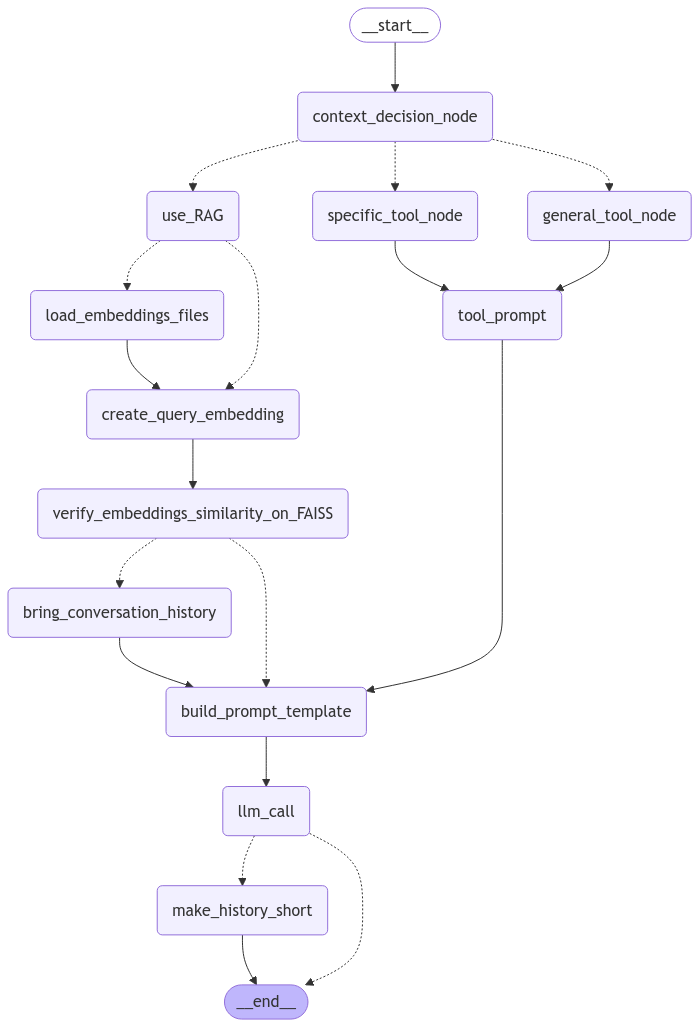

In [11]:
# Inicializa o MemorySaver e compila o gráfico
#checkpointer = MemorySaver()
# Compilar o grafo
graph = builder.compile()

#


# Visualizar o grafo (opcional)
display(Image(graph.get_graph().draw_mermaid_png()))


In [12]:
def call_graph(query, thread="1"):
    # Verificar se a variável `initial_state` está no escopo global
    if 'state' not in globals():
        global initial_state  # Declarar como global para criar ou reutilizar
        initial_state = {
            "graph_state": "START",  # Ponto de entrada do grafo
            "query": query,
            "embeddings": [],  # Inicialmente vazio
            "embeddings_loaded": False,
            "thread": thread,
        }
    
    else:
        initial_state = state
        initial_state["query"] = query
        
    # Executar o grafo
    result = graph.invoke(initial_state)
    
    # Verificar o resultado final
    return result



In [29]:
# Solicitar entrada do usuário
user_input = input("Enter your question or instruction: ")

# Passar o input do usuário para o call_graph
state = call_graph(user_input, thread="1")

# Exibir a resposta do LLM
#print(state["llm_response"])


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


In that case, I will analyze the context again.

Based on the context, I would say that the best tool to answer your question is: 'GENERAL'. 

This is because the context mentions features of the plan, and none of the keys (
Processa a consulta usando a ferramenta geral.
[{'id': 'standard_general', 'type': 'general_info', 'plan': 'standard', 'category': 'subscription plan', 'feature': 'cost', 'details': 'complimentary', 'subgroup': None}, {'id': 'gold star_general', 'type': 'general_info', 'plan': 'gold star', 'category': 'subscription plan', 'feature': 'cost', 'details': 'approx.$8usd/mo', 'subgroup': None}, {'id': 'standard_3', 'type': 'feature', 'plan': 'standard', 'category': 'feature', 'feature': 'manual capture (5mp) and record ⓘ', 'details': '✓', 'subgroup': 'digital keepsakes'}, {'id': 'gold star_3', 'type': 'feature', 'plan': 'gold star', 'category': 'feature', 'feature': 'manual capture (5mp) and record ⓘ', 'details': '✓', 'subgroup': 'digital keepsakes'}, {'id': 'standard_4'

In [14]:
state

{'graph_state': 'make_history_short',
 'query': None,
 'embeddings_loaded': False,
 'query_template': [{'role': 'system',
   'content': "Check if the userer's quesiton can be answered by the content present in the context: If the answer is not in the context, say that you don't know. If the answer is in the context, just reply it based on context. <context>{'ID': 'standard_general', 'TYPE': 'general_info', 'PLAN': 'standard', 'CATEGORY': 'subscription plan', 'FEATURE': 'cost', 'DETAILS': 'complimentary', 'SUBGROUP': None}\n{'ID': 'gold star_general', 'TYPE': 'general_info', 'PLAN': 'gold star', 'CATEGORY': 'subscription plan', 'FEATURE': 'cost', 'DETAILS': 'approx.$8usd/mo', 'SUBGROUP': None}\n{'ID': 'standard_3', 'TYPE': 'feature', 'PLAN': 'standard', 'CATEGORY': 'feature', 'FEATURE': 'manual capture (5mp) and record ⓘ', 'DETAILS': '✓', 'SUBGROUP': 'digital keepsakes'}\n{'ID': 'gold star_3', 'TYPE': 'feature', 'PLAN': 'gold star', 'CATEGORY': 'feature', 'FEATURE': 'manual capture (5mp

In [15]:
#state = call_graph("How can I turn the equipment off?", thread="1")
#print(state["llm_response"])

In [16]:
#######################################################################

In [23]:
state

{'graph_state': 'make_history_short',
 'query': None,
 'embeddings_loaded': False,
 'query_template': [{'role': 'system',
   'content': "Check if the userer's quesiton can be answered by the content present in the context: If the answer is not in the context, say that you don't know. If the answer is in the context, just reply it based on context. <context>{'DETAILS': '✓', 'TYPE': 'feature', 'ID': 'gold star_23', 'PLAN': 'gold star', 'SUBGROUP': 'advanced support', 'CATEGORY': 'feature', 'FEATURE': 'multiple device support\\n* up to 3 pixsee cameras'}\n{'DETAILS': '✓', 'TYPE': 'feature', 'ID': 'gold star_25', 'FEATURE': 'amazon alexa support', 'PLAN': 'gold star', 'SUBGROUP': 'advanced support', 'CATEGORY': 'feature'}\n{'TYPE': 'feature', 'DETAILS': 'x', 'PLAN': 'standard', 'SUBGROUP': 'digital keepsakes', 'ID': 'standard_11', 'FEATURE': 'themed frames - milestone series\\n* 7+ styles and 30 milestones (update periodically)', 'CATEGORY': 'feature'}\n{'TYPE': 'feature', 'PLAN': 'standar

In [30]:
thread_states

{'1': [{'role': 'system',
   'content': [{'DETAILS': '✓',
     'TYPE': 'feature',
     'ID': 'gold star_23',
     'PLAN': 'gold star',
     'SUBGROUP': 'advanced support',
     'CATEGORY': 'feature',
     'FEATURE': 'multiple device support\n* up to 3 pixsee cameras'},
    {'DETAILS': '✓',
     'TYPE': 'feature',
     'ID': 'gold star_25',
     'FEATURE': 'amazon alexa support',
     'PLAN': 'gold star',
     'SUBGROUP': 'advanced support',
     'CATEGORY': 'feature'},
    {'TYPE': 'feature',
     'DETAILS': 'x',
     'PLAN': 'standard',
     'SUBGROUP': 'digital keepsakes',
     'ID': 'standard_11',
     'FEATURE': 'themed frames - milestone series\n* 7+ styles and 30 milestones (update periodically)',
     'CATEGORY': 'feature'},
    {'TYPE': 'feature',
     'PLAN': 'standard',
     'ID': 'standard_21',
     'FEATURE': 'multiple user support ⓘ',
     'DETAILS': '+2 person',
     'SUBGROUP': 'advanced support',
     'CATEGORY': 'feature'},
    {'DETAILS': '✓',
     'TYPE': 'feature',


In [28]:
state["query_template"]

[{'role': 'system',
  'content': "Check if the userer's quesiton can be answered by the content present in the context: If the answer is not in the context, say that you don't know. If the answer is in the context, just reply it based on context. <context>{'DETAILS': '✓', 'TYPE': 'feature', 'ID': 'gold star_25', 'FEATURE': 'amazon alexa support', 'PLAN': 'gold star', 'SUBGROUP': 'advanced support', 'CATEGORY': 'feature'}\n{'DETAILS': '✓', 'TYPE': 'feature', 'ID': 'gold star_23', 'PLAN': 'gold star', 'SUBGROUP': 'advanced support', 'CATEGORY': 'feature', 'FEATURE': 'multiple device support\\n* up to 3 pixsee cameras'}\n{'TYPE': 'feature', 'DETAILS': 'x', 'PLAN': 'standard', 'SUBGROUP': 'digital keepsakes', 'ID': 'standard_11', 'FEATURE': 'themed frames - milestone series\\n* 7+ styles and 30 milestones (update periodically)', 'CATEGORY': 'feature'}\n{'TYPE': 'feature', 'PLAN': 'standard', 'ID': 'standard_21', 'FEATURE': 'multiple user support ⓘ', 'DETAILS': '+2 person', 'SUBGROUP': 'adv